In [4]:
# General Imports
import numpy as np
from numpy import random as rnd
%matplotlib inline
from matplotlib import pyplot as plt
import os,sys,datetime,time,math, warnings,itertools

import pandas as pd
from contextlib import contextmanager

# Snowpark imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window

# Profiling imports
#!pip install ydata_profiling --ignore-installed --user
from ydata_profiling import ProfileReport

In [5]:
# Connection Parameters
connection_parameters = {
    'account':'shsitdl.west-europe.azure',
    'user':'jan-lucas.deinhard@siemens-healthineers.com',
    'authenticator':'externalbrowser',
    'role':'FR_CRMCLOUD_DEV',
    'database':'MARTLAYER',
    'warehouse':'W_CRMCLOUD_P'
}

# Establish Connection
session = Session.builder.configs(connection_parameters).create()

eC = session.table("CRMCLOUD_ELOQUA.\"Contacts\"").select([
    'Contact.Full Name',
    'Contact First Name',
    'Contact Last Name',
    'Contact.Email Address',
    'Contact.Address Country', 
    'Contact.City',
    'Contact.Postal Code',
    'Contact.Address Line 1',
    'Contact.Address Line 2', 
    'Contact.Address Line 3', 
    'Contact.Business Phone', 
    'Contact.Mobile Phone',
    'Contact Job Title', 
    'Contact Status',
    'Contact.SYS_Opt-in',
    'Contact.SYS_Opt-in (Flag)', 
    'OSC Account Number',
    'Contact.Created Date', 
    'Contact.Last Updated Date', 
])
oC = session.table("CRMCLOUD_OSC.\"Contacts\"").select([
    'Contact First Name',
    'Contact Last Name',
    'Contact.E-Mail',
    'Contact.Address Country',
    'Contact.City',
    'Contact.Postal Code',
    'Contact.Address Line 1',
    'Contact.Address Line 2',
    'Contact.Address Line 3',
    'Contact.Address Line 4',
    'Contact.Phone',
    'Contact.Phone Area Code',
    'Contact.Phone Country Code',
    'Contact Job Title',
    'Contact.Status',
    'Contact GDPR (Flag)',
    'Contact Never Call',
    'Contact Never Email',
    'Contact.Do Not Mail (Flag)',
    'ACCOUNT_ID (Contact)',
    'EMPLOYEE_ID (Owner)',
    'Contact.Created Timestamp',
    'Contact.Last Updated Timestamp',
])

df_e = pd.DataFrame(eC.sample(frac=1).collect())
df_o = pd.DataFrame(oC.sample(frac=1).collect())

session.close()

replace_dict = {
    'null':None,
    'NULL':None,
    'Null':None,
    'n/a':None,
    'N/A':None
}

df_o = df_o.replace(replace_dict)
df_e = df_e.replace(replace_dict)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/5dbf1add-202a-4b8d-815b-bf0fb024e033/saml2/?SAMLRequest=nZJRb5swFIX%2FCvKewQaSKbWSVFlZVqS0yxI6rX0z%2BJJaBZvaJiT99TMkkbqH9mFvln3u%2FY7vudPrQ115e9BGKDlDYUCQB7JQXMjdDD1kS3%2BCPGOZ5KxSEmboCAZdz6eG1VVDF619lht4bcFYzzWShvYPM9RqSRUzwlDJajDUFnS7uFvRKCCUGQPaOhw6l3AjHOvZ2oZi3HVd0MWB0jscEUIwucJO1Uu%2BoHeI5nNGo5VVhaouJQf3pw8QISajHuEUjrA%2BF34T8jSCzyj5SWTobZat%2FfXPbYa8xeV3N0qatga9Bb0XBTxsVicDxjnY3m7TLFkFnZubD61WDQTsrdUQGKm6smIvUKi6aa3rHrgTLoHjSu2Em1mazFDzIvhxlb%2Bmxf7RTH7Uf7bh9%2Fjx7Wgmv%2B7khhCWLBP9FLWwO9R7tSuQ9%2FuScNQnnBrTQir7XK27IlHsh5FPvmZhTKMxjaPgajx%2BQl7i%2FAnJ7FB5MT%2F4CGpRaGVUaZWshITB5ZjnZcg4911H5o%2FyCfcn4Tj385KUOYlGQOIY9%2BlFGJ1WiA5O9Px%2FBzPF77uct%2FLeBZUma1WJ4ugtla6Z%2FTjHMAiHG8H9cpBSqJmoFpxrMMblWVWqu9HArFt

MemoryError: Unable to allocate 6.74 MiB for an array with shape (883800,) and data type uint64

In [6]:
profile_osc = ProfileReport(df_o, title="OSC Profiling Report")
profile_osc.to_file(r'C:\\Users\\z003mxpm\\Desktop\\osc_contacts_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile_elo = ProfileReport(df_e, title="ELOQUA Profiling Report")
profile_elo.to_file(r'C:\\Users\\z003mxpm\\Desktop\\eloqua_contacts_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
of_o = df_o[['Contact.E-Mail','Contact First Name','Contact Last Name']]

of_o['Contact.E-Mail normalized'] = of_o['Contact.E-Mail'].str.lower()
of_o['Contact Full Name normalized (synth)'] = of_o[['Contact First Name','Contact Last Name']].apply(lambda x: str(x[0]).strip().lower()+' '+str(x[1]).strip().lower(),axis=1)
of_o['Contact Identifier (synth)'] = of_o[['Contact Full Name normalized (synth)','Contact.E-Mail normalized']].apply(lambda x: x[0]+'|'+str(x[1]).replace(' ',''),axis=1)

of_o = of_o[[
    'Contact.E-Mail normalized',
    'Contact Full Name normalized (synth)',
    'Contact Identifier (synth)'
]]

C:\Users\z003mxpm\AppData\Local\Temp\ipykernel_7876\3021581314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  of_o['Contact.E-Mail normalized'] = of_o['Contact.E-Mail'].str.lower()
C:\Users\z003mxpm\AppData\Local\Temp\ipykernel_7876\3021581314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  of_o['Contact Full Name normalized (synth)'] = of_o[['Contact First Name','Contact Last Name']].apply(lambda x: str(x[0]).strip().lower()+' '+str(x[1]).strip().lower(),axis=1)
C:\Users\z003mxpm\AppData\Local\Tem

In [4]:
of_e = df_e[['Contact.Email Address','Contact First Name','Contact Last Name']]

of_e['Contact.E-Mail normalized'] = of_e['Contact.Email Address'].str.lower()
of_e['Contact Full Name normalized (synth)'] = of_e[['Contact First Name','Contact Last Name']].apply(lambda x: str(x[0]).strip().lower()+' '+str(x[1]).strip().lower(),axis=1)
of_e['Contact Identifier (synth)'] = of_e[['Contact Full Name normalized (synth)','Contact.Email Address']].apply(lambda x: x[0]+'|'+str(x[1]).replace(' ',''),axis=1)

of_e = of_e[[
    'Contact.E-Mail normalized',
    'Contact Full Name normalized (synth)',
    'Contact Identifier (synth)'
]]

C:\Users\z003mxpm\AppData\Local\Temp\ipykernel_7876\1493312112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  of_e['Contact.E-Mail normalized'] = of_e['Contact.Email Address'].str.lower()
C:\Users\z003mxpm\AppData\Local\Temp\ipykernel_7876\1493312112.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  of_e['Contact Full Name normalized (synth)'] = of_e[['Contact First Name','Contact Last Name']].apply(lambda x: str(x[0]).strip().lower()+' '+str(x[1]).strip().lower(),axis=1)
C:\Users\z003mxpm\AppData\Lo

In [5]:
of_o.head()

,Contact.E-Mail normalized,Contact Full Name normalized (synth),Contact Identifier (synth)
0,None,貴也 河俣,貴也 河俣|None
1,None,祥子 荒井,祥子 荒井|None
2,None,啓子 荒川,啓子 荒川|None
3,None,千佳 戸倉,千佳 戸倉|None
4,None,保 奥秋,保 奥秋|None


In [6]:
of_e.head()

,Contact.E-Mail normalized,Contact Full Name normalized (synth),Contact Identifier (synth)
0,ekleinert@rwjuhr.com,eric kleinert,eric kleinert|ekleinert@rwjuhr.com
1,m.van.buul@antoniusziekenhuis.nl,m.m.c. van buul,m.m.c. van buul|m.van.buul@antoniusziekenhuis.nl
2,linda.d.thompson@hitchcock.org,none none,none none|linda.d.thompson@hitchcock.org
3,bridges.mellena@mayo.edu,mellena bridges,mellena bridges|bridges.mellena@mayo.edu
4,1076172170@qq.com,王茂飞 王,王茂飞 王|1076172170@qq.com


In [8]:
from matplotlib_venn import venn2

In [7]:
l_osc = set(of_o['Contact Identifier (synth)'].tolist())
l_elo = set(of_e['Contact Identifier (synth)'].tolist())

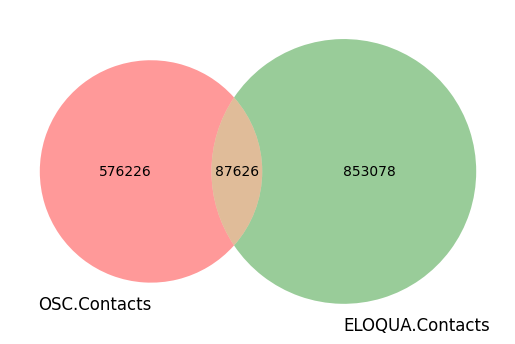

In [9]:
venn2(
    [l_osc, l_elo],
    set_labels=('OSC.Contacts', 'ELOQUA.Contacts')
)
plt.show()

In [15]:
ct_o = of_o[['Contact Identifier (synth)']].groupby(['Contact Identifier (synth)']).size().reset_index(name='counts')
ct_e = of_e[['Contact Identifier (synth)']].groupby(['Contact Identifier (synth)']).size().reset_index(name='counts')

In [19]:
ct_o[ct_o['counts']==1].shape[0]/ct_o.shape[0]

0.8001075540933823

In [20]:
ct_e[ct_e['counts']==1].shape[0]/ct_e.shape[0]

0.9999978739327142

In [21]:
ct_o[ct_o['counts']>1]

,Contact Identifier (synth),counts
5,# #|None,2
23,(col) i sinha|doctorsinha@gmail.com,28
33,* *|None,20
37,* ansari|None,2
66,* malupari|None,2
...,...,...
663775,ｚｈｅｎｇ ｒｏｂｅｒｔ|None,2
663784,ｰ 伊藤|None,2
663786,ｰ 佐藤|None,4
663789,ｰ 加藤|None,3
